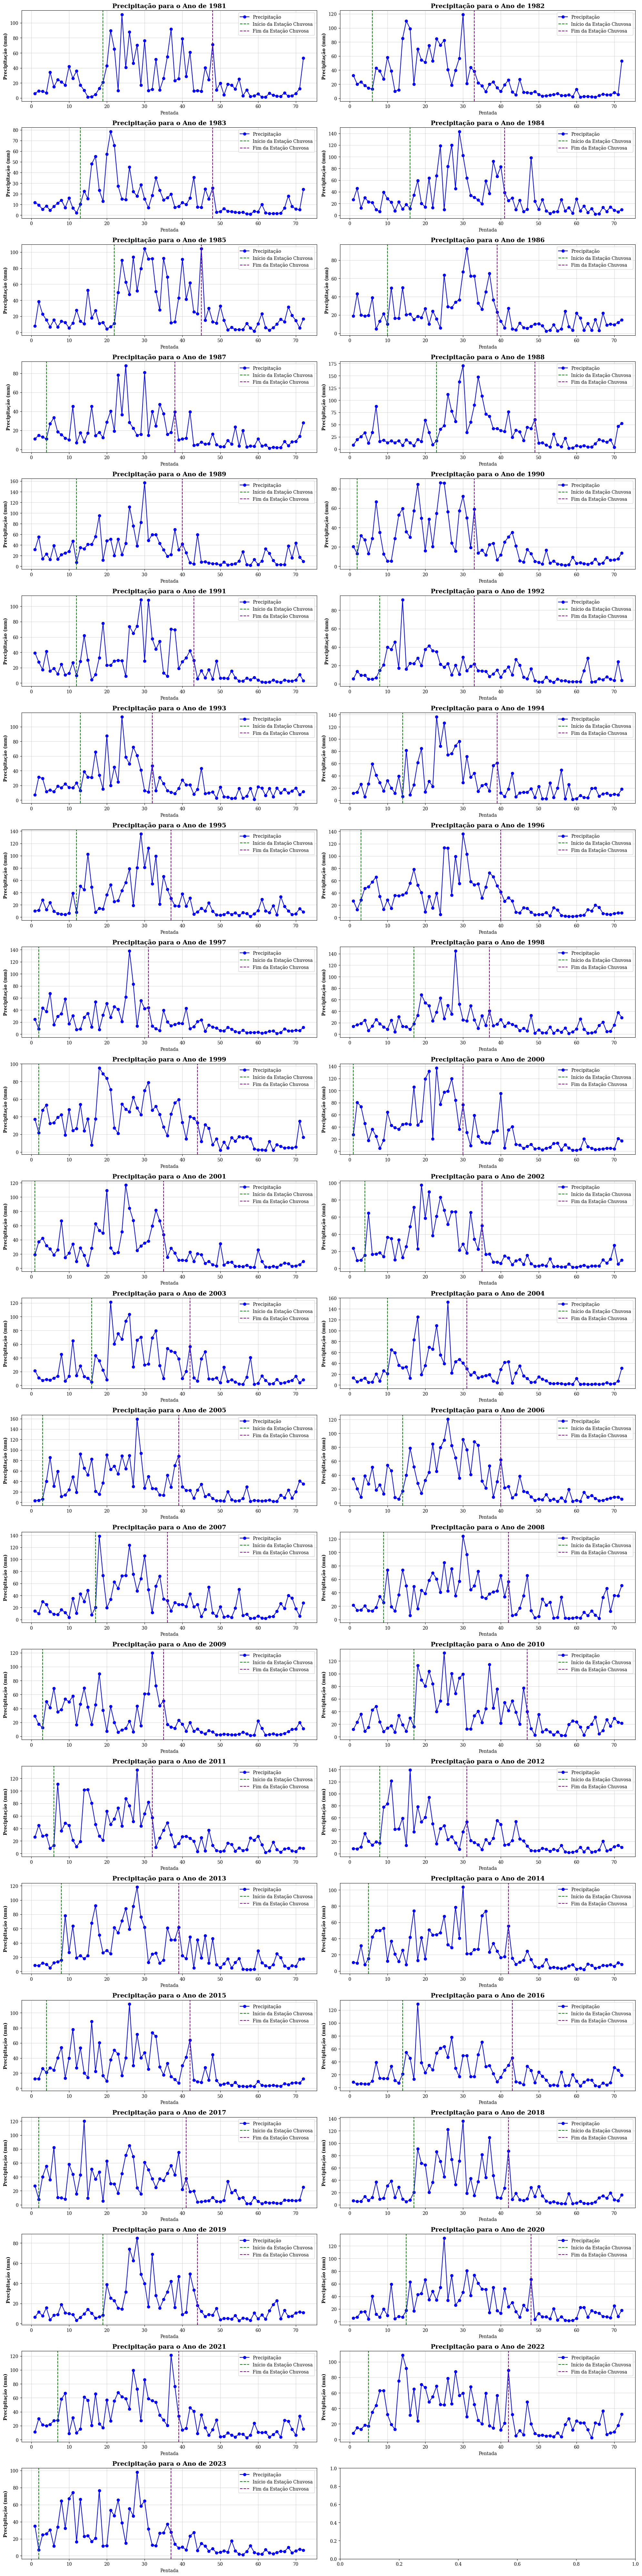

     Ano  Pentada_Início_Chuva  Pentada_Fim_Chuva  Duração_Chuva  Duração_Seca
0   1981                    19                 48             29            44
1   1982                     6                 33             27            46
2   1983                    13                 48             35            38
3   1984                    16                 41             25            48
4   1985                    22                 45             23            50
5   1986                    10                 39             29            44
6   1987                     4                 38             34            39
7   1988                    23                 49             26            47
8   1989                    12                 40             28            45
9   1990                     2                 33             31            42
10  1991                    12                 43             31            42
11  1992                     8                 33   

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDesmatada1.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Lista para armazenar informações da estação seca e chuvosa
season_info = []

# Loop pelos anos para calcular A(day) e identificar início e fim das estações
for year in range(1981, 2024):  # Ajustado para incluir 2023
    year_data = df_filtered[df_filtered["Ano"] == year].copy()

    if year_data.empty:
        print(f"Ano {year} não possui dados suficientes para cálculo.")
        continue

    # Calcular a média anual diária
    R_mean = year_data["Precipitação"].mean()

    # Calcular A(day) acumulando precipitação e subtraindo a média acumulada
    year_data["A_day"] = year_data["Precipitação"].cumsum() - R_mean * year_data["Pentada"]

    # Identificar os pontos de mudança em A_day (início e fim da estação chuvosa)
    try:
        min_index = year_data["A_day"].idxmin()  # Índice do mínimo de A(day)
        max_index = year_data["A_day"].idxmax()  # Índice do máximo de A(day)

        # Garantir que o início (mínimo) vem antes do fim (máximo)
        if min_index < max_index:
            inicio_chuva = year_data.loc[min_index, "Pentada"]
            fim_chuva = year_data.loc[max_index, "Pentada"]
        else:
            inicio_chuva = year_data.loc[max_index, "Pentada"]
            fim_chuva = year_data.loc[min_index, "Pentada"]
    except IndexError:
        print(f"Ano {year} não possui dados suficientes para identificar estação chuvosa.")
        continue

    # Calcular duração da estação seca como complementares à estação chuvosa
    pentadas_total = 73  # Total de pentadas no ano
    duracao_chuva = fim_chuva - inicio_chuva
    duracao_seca = pentadas_total - duracao_chuva

    # Adicionar informações ao dataframe
    season_info.append({
        "Ano": year,
        "Pentada_Início_Chuva": inicio_chuva,
        "Pentada_Fim_Chuva": fim_chuva,
        "Duração_Chuva": duracao_chuva,
        "Duração_Seca": duracao_seca
    })

# Transformar as informações da estação em DataFrame
season_df = pd.DataFrame(season_info)

# Salvar as informações em um arquivo Excel
output_excel_path = "/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Resultados/Estacoes_Resumo.xlsx"
season_df.to_excel(output_excel_path, index=False)

# Plotar gráficos (mesmo método que antes, mas adaptado para o novo conceito)
output_path = "/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Resultados/AreaDesmatada3_analise.pdf"
fig, axes = plt.subplots(nrows=22, ncols=2, figsize=(20, 80))
axes = axes.flatten()

for i, year in enumerate(range(1981, 2024)):
    ax = axes[i]
    year_data = df_filtered[df_filtered["Ano"] == year]

    if year_data.empty:
        ax.set_title(f"Dados faltantes - {year}")
        continue

    ax.plot(year_data["Pentada"], year_data["Precipitação"], label="Precipitação", marker='o', color='blue')

    if "A_day" in year_data.columns:
        ax.plot(year_data["Pentada"], year_data["A_day"], label="A(day)", color="red", linestyle="--")

    dry_year = season_df[season_df["Ano"] == year]
    if not dry_year.empty:
        ax.axvline(x=dry_year["Pentada_Início_Chuva"].values[0], color="green", linestyle="--", label="Início da Estação Chuvosa")
        ax.axvline(x=dry_year["Pentada_Fim_Chuva"].values[0], color="purple", linestyle="--", label="Fim da Estação Chuvosa")

    ax.set_title(f"Precipitação para o Ano de {year}", fontweight='bold', fontsize=14)
    ax.set_xlabel("Pentada")
    ax.set_ylabel("Precipitação (mm)", fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.savefig(output_path, format='pdf')
plt.show()

# Exibir as informações da estação
print(season_df)

In [13]:
# Cálculos estatísticos sobre a duração da estação seca considerando todo o período fora da estação chuvosa
def analyze_season_data(season_df):
    # Duração média da estação seca
    mean_duration = season_df["Duração_Seca"].mean()

    # Duração mínima e máxima
    min_duration = season_df["Duração_Seca"].min()
    max_duration = season_df["Duração_Seca"].max()

    # Ano com menor e maior duração
    min_year = season_df.loc[season_df["Duração_Seca"].idxmin(), "Ano"]
    max_year = season_df.loc[season_df["Duração_Seca"].idxmax(), "Ano"]

    # Aumento percentual da duração ao longo dos anos
    initial_duration = season_df.iloc[0]["Duração_Seca"]
    final_duration = season_df.iloc[-1]["Duração_Seca"]
    percentage_change = ((final_duration - initial_duration) / initial_duration) * 100

    # Exibir resultados no terminal
    print("\n--- Análise da Duração da Estação Seca ---")
    print(f"Duração Média (pentadas): {mean_duration:.2f}")
    print(f"Duração Mínima (pentadas): {min_duration} (Ano: {min_year})")
    print(f"Duração Máxima (pentadas): {max_duration} (Ano: {max_year})")
    print(f"Aumento Percentual ao longo dos anos: {percentage_change:.2f}%\n")

    # Retornar os resultados (caso precise usá-los depois)
    return {
        "Duração Média (pentadas)": mean_duration,
        "Duração Mínima (pentadas)": min_duration,
        "Aumento Percentual (%)": percentage_change
    }

# Atualizar cálculo da estação seca para incluir todos os dias fora da estação chuvosa
for year in range(1981, 2024):  # Ajustado para incluir 2023
    year_data = df_filtered[df_filtered["Ano"] == year].copy()

    if year_data.empty:
        print(f"Ano {year} não possui dados suficientes para cálculo.")
        continue

    # Calcular a média anual diária
    R_mean = year_data["Precipitação"].mean()

    # Calcular A(day) acumulando precipitação e subtraindo a média acumulada
    year_data["A_day"] = year_data["Precipitação"].cumsum() - R_mean * year_data["Pentada"]

    # Identificar os pontos de mudança em A_day (início e fim da estação seca)
    try:
        min_index = year_data["A_day"].idxmin()  # Índice do mínimo de A(day)
        max_index = year_data["A_day"].idxmax()  # Índice do máximo de A(day)

        # Garantir que o início (mínimo) vem antes do fim (máximo)
        if min_index < max_index:
            inicio_chuvosa = year_data.loc[min_index, "Pentada"]
            fim_chuvosa = year_data.loc[max_index, "Pentada"]
        else:
            inicio_chuvosa = year_data.loc[max_index, "Pentada"]
            fim_chuvosa = year_data.loc[min_index, "Pentada"]

        # Determinar os dias fora da estação chuvosa como pertencentes à estação seca
        dias_seca = 73 - (fim_chuvosa - inicio_chuvosa)  # Total de pentadas no ano é 73
    except IndexError:
        print(f"Ano {year} não possui dados suficientes para identificar estação chuvosa.")
        continue

    # Adicionar informações ao dataframe
    season_info.append({
        "Ano": year,
        "Pentada_Início_Chuvosa": inicio_chuvosa,
        "Pentada_Fim_Chuvosa": fim_chuvosa,
        "Duração_Seca": dias_seca
    })

# Transformar as informações da estação em DataFrame
season_df = pd.DataFrame(season_info)

# Realizar análises e exibir no terminal
analysis_results = analyze_season_data(season_df)




--- Análise da Duração da Estação Seca ---
Duração Média (pentadas): 43.53
Duração Mínima (pentadas): 31 (Ano: 1999)
Duração Máxima (pentadas): 54 (Ano: 1993)
Aumento Percentual ao longo dos anos: -13.64%



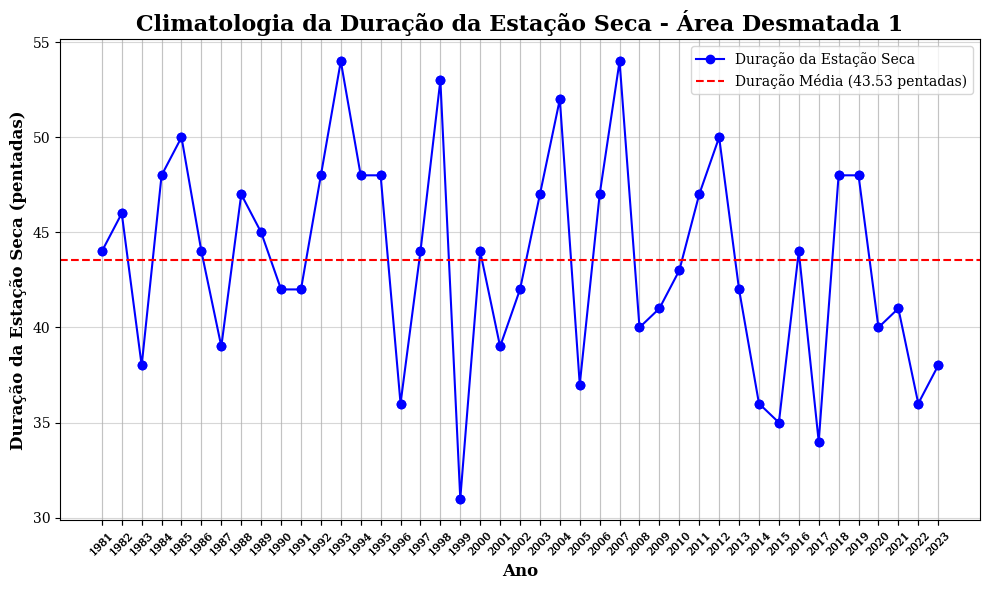

In [16]:
# Função para plotar o gráfico com as conexões adequadas
def plot_dry_season_duration(season_df):
    # Ordenar os dados pelo ano (caso não estejam)
    season_df = season_df.sort_values(by="Ano")

    # Remover possíveis valores NaN
    season_df = season_df.dropna(subset=["Ano", "Duração_Seca"])

    # Cálculo da duração média
    mean_duration = season_df["Duração_Seca"].mean()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(season_df["Ano"], season_df["Duração_Seca"], label="Duração da Estação Seca", color='blue', marker='o')
    plt.axhline(mean_duration, color='red', linestyle='--', label=f"Duração Média ({mean_duration:.2f} pentadas)")

    # Configurar título e rótulos
    plt.title("Climatologia da Duração da Estação Seca - Área Desmatada 1", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Duração da Estação Seca (pentadas)", fontsize=12, fontweight='bold')
    plt.xticks(season_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_dry_season_duration(season_df)



In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Dados necessários (simulados)
anos = season_df["Ano"]
inicio_chuvosa = season_df["Pentada_Início_Chuvosa"]
fim_chuvosa = season_df["Pentada_Fim_Chuvosa"]

# Estimativa da duração da estação seca com base nos dias fora da estação chuvosa
duracao_seca = 73 - (fim_chuvosa - inicio_chuvosa)

# Criar matriz para o diagrama de Hovmöller usando precipitação
hovmoller_matrix = np.zeros((len(anos), 73))  # 73 pentadas em um ano

# Preenchendo a matriz com dados de precipitação
for i, year in enumerate(anos):
    year_data = df_filtered[df_filtered["Ano"] == year]
    for pentada in year_data["Pentada"]:
        hovmoller_matrix[i, pentada - 1] = year_data.loc[year_data["Pentada"] == pentada, "Precipitação"].values[0]

# Calcular os valores médios de início e fim da estação chuvosa
inicio_chuvosa_medio = inicio_chuvosa.mean()
fim_chuvosa_medio = fim_chuvosa.mean()

# Identificar os anos com maior duração da estação seca
top_duracao_indices = duracao_seca.nlargest(6).index
seca_anos = anos[top_duracao_indices]
seca_pentadas = [36] * len(seca_anos)  # Pentada central da estação seca como exemplo

# Configurações do gráfico
plt.figure(figsize=(12, 8))
plt.imshow(
    hovmoller_matrix,
    aspect="auto",
    cmap="Blues",  # Gradiente de azul
    origin="lower",
    extent=[1, 73, anos.min(), anos.max()],
)

# Adicionando áreas para estações seca e chuvosa
plt.axvspan(1, inicio_chuvosa_medio, color="lightyellow", alpha=0.3, label="Estação Seca")
plt.axvspan(fim_chuvosa_medio, 73, color="lightyellow", alpha=0.3)
plt.axvspan(inicio_chuvosa_medio, fim_chuvosa_medio, color="lightblue", alpha=0.3, label="Estação Chuvosa")

# Adicionar texto para identificar as estações
plt.text(10, anos.max() + 0.5, "Estação Chuvosa (Início)", fontsize=10, ha="center", fontweight="bold")
plt.text(25, anos.max() + 0.5, "Estação Chuvosa", fontsize=10, ha="center", fontweight="bold")
plt.text(40, anos.max() + 0.5, "Estação Chuvosa (Fim)", fontsize=10, ha="center", fontweight="bold")

# Adicionar linhas tracejadas para o início e fim médio da estação chuvosa
plt.axvline(x=inicio_chuvosa_medio, color="green", linestyle="--", linewidth=2, label="Início Médio Estação Chuvosa")
plt.axvline(x=fim_chuvosa_medio, color="orange", linestyle="--", linewidth=2, label="Fim Médio Estação Chuvosa")

# Marcar eventos de seca com linhas e anotações
for ano, pentada in zip(seca_anos, seca_pentadas):
    plt.axhline(y=ano, color="red", linestyle="--", linewidth=1)
    plt.text(
        pentada,
        ano + 0.5,
        f"Seca {ano}",
        color="red",
        fontsize=8,
        ha="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )

# Barra de cores e rótulos
cbar = plt.colorbar(label="Precipitação (mm)")
cbar.ax.tick_params(labelsize=9)
plt.title(
    "Diagrama de Hovmöller - Estação Seca e Chuvosa - Área Dematada 1",
    fontsize=14,
    fontweight="bold",
    y=1.05
)
plt.xlabel("Pentadas", fontsize=12, fontweight="bold")
plt.ylabel("Ano", fontsize=12, fontweight="bold")
plt.xticks(
    ticks=np.linspace(1, 73, num=12),
    labels=["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"],
    fontsize=10
)Seca
plt.yticks(ticks=anos, labels=anos, fontsize=8)

plt.grid(axis="x", color="gray", linestyle="--", alpha=0.5)

# Ajustar layout e mostrar
plt.tight_layout()
plt.legend(loc="upper right", fontsize=9)
plt.show()


SyntaxError: invalid syntax (1408917593.py, line 82)


--- Análise de Regressão Linear ---
Equação da linha de tendência: Duração = -0.11 * Ano + 267.86
Inclinação (m): -0.11
Coeficiente de determinação (R²): 0.06


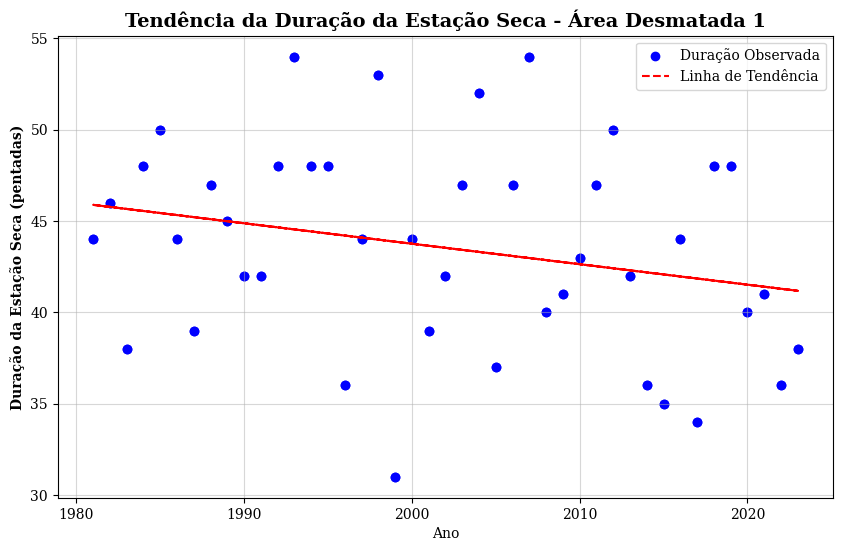

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Dados para análise
anos = season_df["Ano"]
duracao_seca = season_df["Duração_Seca"]

# Ajustar uma regressão linear (y = mx + b)
X = sm.add_constant(anos)  # Adiciona a constante (intercepto)
model = sm.OLS(duracao_seca, X).fit()  # Ajusta o modelo de regressão
trend_line = model.predict(X)  # Calcula a linha de tendência

# Coeficientes da regressão
coef_angular = model.params[1]  # Inclinação (m)
coef_intercepto = model.params[0]  # Intercepto (b)
r_squared = model.rsquared  # Coeficiente de determinação (qualidade do ajuste)

# Exibir resultados
print("\n--- Análise de Regressão Linear ---")
print(f"Equação da linha de tendência: Duração = {coef_angular:.2f} * Ano + {coef_intercepto:.2f}")
print(f"Inclinação (m): {coef_angular:.2f}")
print(f"Coeficiente de determinação (R²): {r_squared:.2f}")

# Criar um DataFrame com os resultados para exportação
resultados = pd.DataFrame({
    "Ano": anos,
    "Duração Observada": duracao_seca,
    "Linha de Tendência": trend_line
})

# Salvar os dados no Excel
resultados.to_excel("dados_analise_area_preservada3.xlsx", index=False)

# Plotar os dados e a linha de tendência
plt.figure(figsize=(10, 6))
plt.scatter(anos, duracao_seca, color='blue', label="Duração Observada")
plt.plot(anos, trend_line, color='red', linestyle='--', label="Linha de Tendência")
plt.title("Tendência da Duração da Estação Seca - Área Desmatada 1", fontweight='bold', fontsize=14)
plt.xlabel("Ano")
plt.ylabel("Duração da Estação Seca (pentadas)", fontweight='bold')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import statsmodels.api as sm

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDesmatada1.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Criar precipitation_df baseado nos dados filtrados
precipitation_df = df_filtered.groupby("Ano")["Precipitação"].sum().reset_index()
precipitation_df.rename(columns={"Precipitação": "Total_Precipitação"}, inplace=True)

# Função para análise de precipitação
def analyze_precipitation_data(precipitation_df):
    # Precipitação média anual
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()

    # Precipitação mínima e máxima
    min_precipitation = precipitation_df["Total_Precipitação"].min()
    max_precipitation = precipitation_df["Total_Precipitação"].max()

    # Ano com menor e maior precipitação
    min_year = precipitation_df.loc[precipitation_df["Total_Precipitação"].idxmin(), "Ano"]
    max_year = precipitation_df.loc[precipitation_df["Total_Precipitação"].idxmax(), "Ano"]

    # Aumento percentual da precipitação ao longo dos anos
    initial_precipitation = precipitation_df.iloc[0]["Total_Precipitação"]
    final_precipitation = precipitation_df.iloc[-1]["Total_Precipitação"]
    percentage_change = ((final_precipitation - initial_precipitation) / initial_precipitation) * 100

    # Exibir resultados no terminal
    print("\n--- Análise da Precipitação Anual Área Desmatada 1 ---")
    print(f"Precipitação Média Anual (mm): {mean_precipitation:.2f}")
    print(f"Precipitação Mínima Anual (mm): {min_precipitation} (Ano: {min_year})")
    print(f"Precipitação Máxima Anual (mm): {max_precipitation} (Ano: {max_year})")
    print(f"Aumento Percentual ao longo dos anos: {percentage_change:.2f}%\n")

    # Retornar os resultados
    return {
        "Precipitação Média Anual (mm)": mean_precipitation,
        "Precipitação Mínima Anual (mm)": min_precipitation,
        "Ano Mínimo": min_year,
        "Precipitação Máxima Anual (mm)": max_precipitation,
        "Ano Máximo": max_year,
        "Aumento Percentual (%)": percentage_change
    }

# Realizar a análise de precipitação
precipitation_analysis = analyze_precipitation_data(precipitation_df)

# Exibir o DataFrame de resultados
print(precipitation_analysis)


--- Análise da Precipitação Anual Área Desmatada 1 ---
Precipitação Média Anual (mm): 1929.00
Precipitação Mínima Anual (mm): 1106.4005809184462 (Ano: 1983)
Precipitação Máxima Anual (mm): 2611.1970709014095 (Ano: 2010)
Aumento Percentual ao longo dos anos: -10.11%

{'Precipitação Média Anual (mm)': 1928.9995873390433, 'Precipitação Mínima Anual (mm)': 1106.4005809184462, 'Ano Mínimo': 1983, 'Precipitação Máxima Anual (mm)': 2611.1970709014095, 'Ano Máximo': 2010, 'Aumento Percentual (%)': -10.106741742818642}


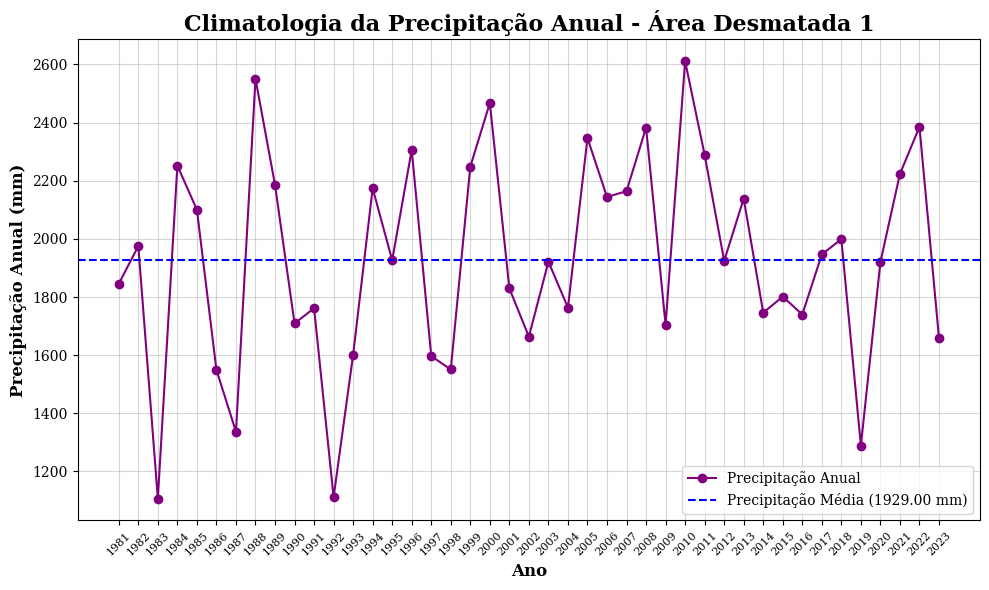

Precipitação Média Anual: 1929.00 mm


In [8]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico
def plot_precipitation_trend(precipitation_df):
    # Cálculo da precipitação média anual
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(precipitation_df["Ano"], precipitation_df["Total_Precipitação"], label="Precipitação Anual", color='purple', marker='o')
    plt.axhline(mean_precipitation, color='blue', linestyle='--', label=f"Precipitação Média ({mean_precipitation:.2f} mm)")

    # Configurar título e rótulos
    plt.title("Climatologia da Precipitação Anual - Área Desmatada 1", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold')
    plt.xticks(precipitation_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_precipitation_trend(precipitation_df)



--- Precipitação Média Anual ---
Ano
1981    1845.529124
1982    1975.392688
1983    1106.400581
1984    2251.969200
1985    2100.210905
1986    1549.217014
1987    1336.486285
1988    2550.727172
1989    2185.765322
1990    1709.005195
1991    1761.521998
1992    1111.359218
1993    1601.581522
1994    2174.090556
1995    1926.446618
1996    2306.140257
1997    1596.746261
1998    1550.633254
1999    2248.324381
2000    2467.235300
2001    1829.576607
2002    1663.301591
2003    1921.493227
2004    1763.554162
2005    2346.738761
2006    2144.079993
2007    2164.125610
2008    2382.681741
2009    1704.654366
2010    2611.197071
2011    2288.829682
2012    1924.420391
2013    2138.462294
2014    1745.913867
2015    1801.340324
2016    1739.781722
2017    1946.405225
2018    1999.003783
2019    1288.868708
2020    1920.271828
2021    2223.161990
2022    2385.330202
2023    1659.006261
Name: Total_Precipitação, dtype: float64


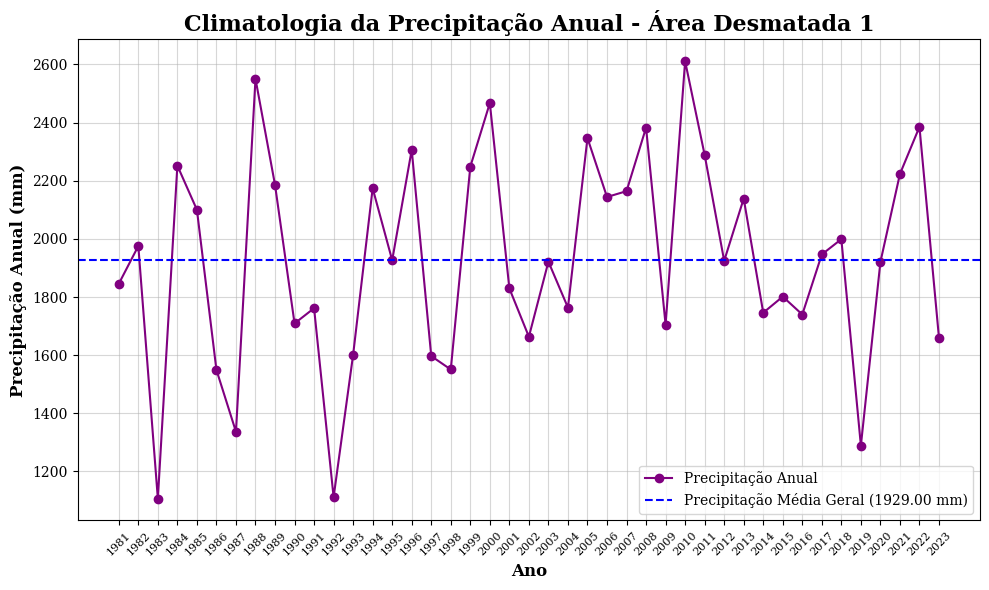

In [9]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico e calcular a precipitação média anual
def plot_precipitation_trend(precipitation_df):
    # Cálculo da precipitação média anual por ano
    yearly_mean_precipitation = precipitation_df.groupby("Ano")["Total_Precipitação"].mean()

    # Exibir a precipitação média anual no terminal
    print("\n--- Precipitação Média Anual ---")
    print(yearly_mean_precipitation)

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(precipitation_df["Ano"], precipitation_df["Total_Precipitação"], label="Precipitação Anual", color='purple', marker='o')
    plt.axhline(precipitation_df["Total_Precipitação"].mean(), color='blue', linestyle='--', label=f"Precipitação Média Geral ({precipitation_df['Total_Precipitação'].mean():.2f} mm)")

    # Configurar título e rótulos
    plt.title("Climatologia da Precipitação Anual - Área Desmatada 1", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold')
    plt.xticks(precipitation_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

    # Retornar os valores de precipitação média anual
    return yearly_mean_precipitation

# Chamar a função e exibir os resultados
yearly_mean = plot_precipitation_trend(precipitation_df)


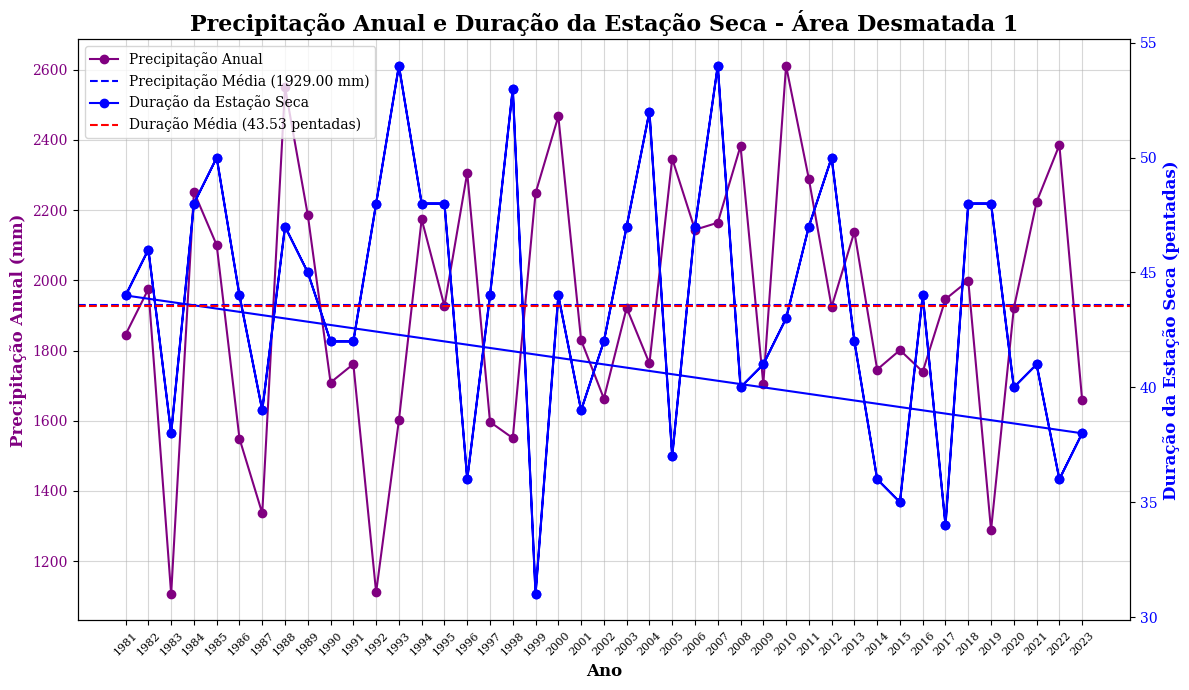

In [15]:
import matplotlib.pyplot as plt

# Função para combinar os gráficos de precipitação e duração da estação seca
def plot_combined_trend(precipitation_df, season_df):
    # Criar a figura e os eixos
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Gráfico da precipitação (eixo esquerdo)
    ax1.plot(
        precipitation_df["Ano"], precipitation_df["Total_Precipitação"], 
        label="Precipitação Anual", color='purple', marker='o'
    )
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()
    ax1.axhline(mean_precipitation, color='blue', linestyle='--', label=f"Precipitação Média ({mean_precipitation:.2f} mm)")
    ax1.set_xlabel("Ano", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')
    ax1.grid(alpha=0.5)

    # Gráfico da duração da estação seca (eixo direito)
    ax2 = ax1.twinx()
    ax2.plot(
        season_df["Ano"], season_df["Duração_Seca"], 
        label="Duração da Estação Seca", color='blue', marker='o'
    )
    mean_duration = season_df["Duração_Seca"].mean()
    ax2.axhline(mean_duration, color='red', linestyle='--', label=f"Duração Média ({mean_duration:.2f} pentadas)")
    ax2.set_ylabel("Duração da Estação Seca (pentadas)", fontsize=12, fontweight='bold', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Configurar ticks do eixo x para mostrar todos os anos
    all_years = sorted(precipitation_df["Ano"].unique())  # Listar todos os anos únicos
    ax1.set_xticks(all_years)  # Definir os anos como ticks no eixo x
    ax1.set_xticklabels(all_years, rotation=45, fontsize=8)  # Rotacionar os anos para melhor legibilidade

    # Combinar legendas dos dois eixos
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=10)

    # Título do gráfico
    plt.title("Precipitação Anual e Duração da Estação Seca - Área Desmatada 1", fontsize=16, fontweight='bold')

    # Ajustar layout
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()

# Chamar a função para plotar os gráficos combinados
plot_combined_trend(precipitation_df, season_df)
